In [1]:
import awkward as awk
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
plt.style.use("../figures.mplstyle")
import numpy as np
import os
try: os.mkdir("figures")
except FileExistsError: pass

In [2]:
filename = {"IceCube":"IceCube_DIS.parquet",
            "DUNE":"DUNE_DIS.parquet",
            "ATLAS":"ATLAS_DIS.parquet"}

Erange = {"IceCube":(1e-1,2e6),
          "DUNE":(1e-1,2e6),
          "ATLAS":(1e-2,1e6)}

Crange = {"IceCube":(-1,1),
          "DUNE":(-1,1),
          "ATLAS":(0.8,1)}

In [3]:
# Kinematic distributions

def plot_kinematics(data,k,nbins=30,savestr=None):
    
    _Erange = Erange[k]
    _Crange = Crange[k]
    
    fig,ax = plt.subplots(2,1,figsize=(8,12))
    
    #twin0 = ax[0].twinx()
    #twin1 = ax[1].twinx()
    
    # for _ax in [ax[0],ax[1]]:
    #     _ax.set_prop_cycle(color=['red', 'green', 'blue'])
    
    
    # initial nu
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])

    # muon
    muon_flag = data["secondary_types"]=='ParticleType.MuMinus'
    muon_momenta = data["secondary_momenta"][muon_flag]
    # mask out entries that are not muon
    muon_momenta = awk.mask(muon_momenta, awk.num(muon_momenta,axis=2)>0)
    muon_momenta = np.squeeze(muon_momenta[~awk.is_none(muon_momenta,axis=1)])

    # hadron
    hadron_flag = data["secondary_types"]=='ParticleType.Hadrons'
    hadron_momenta = data["secondary_momenta"][hadron_flag]
    # mask out entries that are not hadron
    hadron_momenta = awk.mask(hadron_momenta, awk.num(hadron_momenta,axis=2)>0)
    hadron_momenta = np.squeeze(hadron_momenta[~awk.is_none(hadron_momenta,axis=1)])

    kwargs = {"bins":np.logspace(np.log10(_Erange[0]),np.log10(_Erange[1]),nbins),
              "weights":data["event_weight"],
              "histtype":"step"}

    # Energy
    nPhys,ebins = np.histogram(nu_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    bwPhys = ebins[1:] - ebins[:-1]
    ax[0].step(ebins,np.append(nPhys/bwPhys,(nPhys/bwPhys)[-1]),where="post",label=r"Initial $\nu$")
    n,ebins = np.histogram(muon_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    bw = ebins[1:] - ebins[:-1]
    ax[0].step(ebins,np.append(n/bw,(n/bw)[-1]),where="post",label=r"Outgoing $\mu$")
    n,ebins = np.histogram(hadron_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    bw = ebins[1:] - ebins[:-1]
    ax[0].step(ebins,np.append(n/bw,(n/bw)[-1]),where="post",label="Outgoing Hadrons")
    
    kwargs["weights"] = None
    kwargs["ls"] = "--"
    
    # nGen,ebins = np.histogram(nu_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    # bwGen = ebins[1:] - ebins[:-1]
    # twin0.step(ebins[:-1],nGen/bwGen,where="post",ls=kwargs["ls"])
    # n,ebins = np.histogram(muon_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    # bw = ebins[1:] - ebins[:-1]
    # twin0.step(ebins[:-1],n/bw,where="post",ls=kwargs["ls"])
    # n,ebins = np.histogram(hadron_momenta[:,0],bins=kwargs["bins"],weights=kwargs["weights"])
    # bw = ebins[1:] - ebins[:-1]
    # twin0.step(ebins[:-1],n/bw,where="post",ls=kwargs["ls"])
    
    # Angle
    def CosTheta(momenta):
        return momenta[:,3]/np.linalg.norm(momenta[:,1:],axis=-1)
    
    kwargs["bins"] = np.linspace(_Crange[0],_Crange[1],nbins)
    kwargs["weights"] = data["event_weight"]
    kwargs["ls"] = None
    
    # ax[1].hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    # ax[1].hist(CosTheta(muon_momenta),**kwargs,label=r"Outgoing $\mu$")
    # ax[1].hist(CosTheta(hadron_momenta),**kwargs,label=r"Outgoing Hadrons")
    n,ebins = np.histogram(CosTheta(nu_momenta),bins=kwargs["bins"],weights=kwargs["weights"])
    bw = ebins[1:] - ebins[:-1]
    ax[1].step(ebins,np.append(n/bw,(n/bw)[-1]),where="post",label=r"Initial $\nu$")
    n,ebins = np.histogram(CosTheta(muon_momenta),bins=kwargs["bins"],weights=kwargs["weights"])
    bw = ebins[1:] - ebins[:-1]
    ax[1].step(ebins,np.append(n/bw,(n/bw)[-1]),where="post",label=r"Outgoing $\mu$")
    n,ebins = np.histogram(CosTheta(hadron_momenta),bins=kwargs["bins"],weights=kwargs["weights"])
    bw = ebins[1:] - ebins[:-1]
    ax[1].step(ebins,np.append(n/bw,(n/bw)[-1]),where="post",label="Outgoing Hadrons")
    
    kwargs["weights"] = None
    kwargs["ls"] = "--"
    
    #m,_,_ = twin1.hist(CosTheta(nu_momenta),**kwargs,label=r"Initial $\nu$")
    #twin1.hist(CosTheta(muon_momenta),**kwargs,label=r"Outgoing $\mu$")
    #twin1.hist(CosTheta(hadron_momenta),**kwargs,label=r"Outgoing Hadrons")
    
    ax[0].legend(loc="upper right")
    ax[0].loglog()
    #twin0.loglog()
    ax[0].set_xlabel("Energy [GeV]")
    ax[0].set_ylabel(r"$dN/dE~[{\rm GeV}^{-1}]$")
    #twin0.set_ylabel("Generated Events")
    ax[0].set_xlim(*_Erange)
    ax[0].set_ylim(1e-8,1e-2)
    #ax[0].set_ylim(0.5*min(nPhys/bwPhys),10*max(nPhys/bwPhys))
    #twin0.set_ylim(0.5*min(nGen/bwGen),10*max(nGen/bwGen))
    
    ax[1].legend(loc="upper left" if k=="ATLAS" else "lower right")
    #twin1.legend()
    ax[1].semilogy()
    #twin1.semilogy()
    ax[1].set_xlabel(r"$\cos \theta$")
    ax[1].set_ylabel(r"$dN/d(\cos \theta)$")
    #twin1.set_ylabel("Generated Events")
    ax[1].set_xlim(*_Crange)
    #twin1.set_ylim(1,2*max(m))
        
    if savestr is not None:
        plt.savefig(savestr+"_kinematics.pdf",dpi=100)
    plt.show()

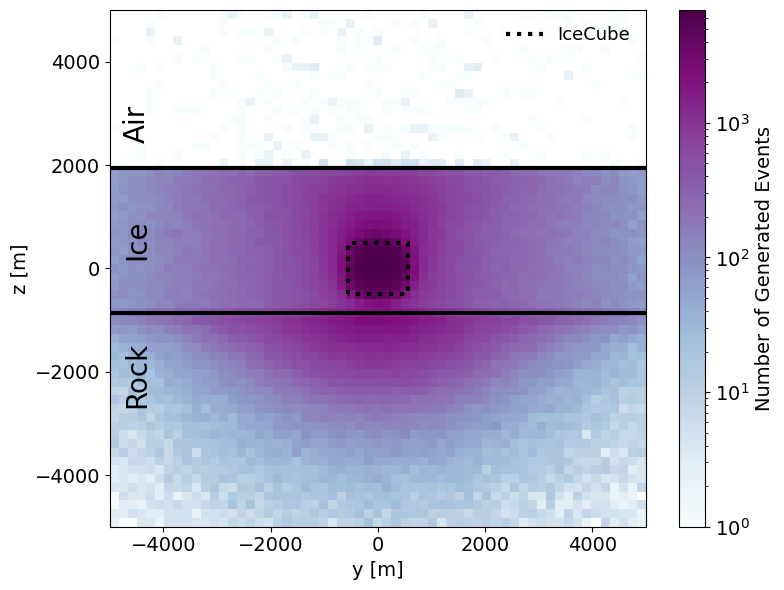

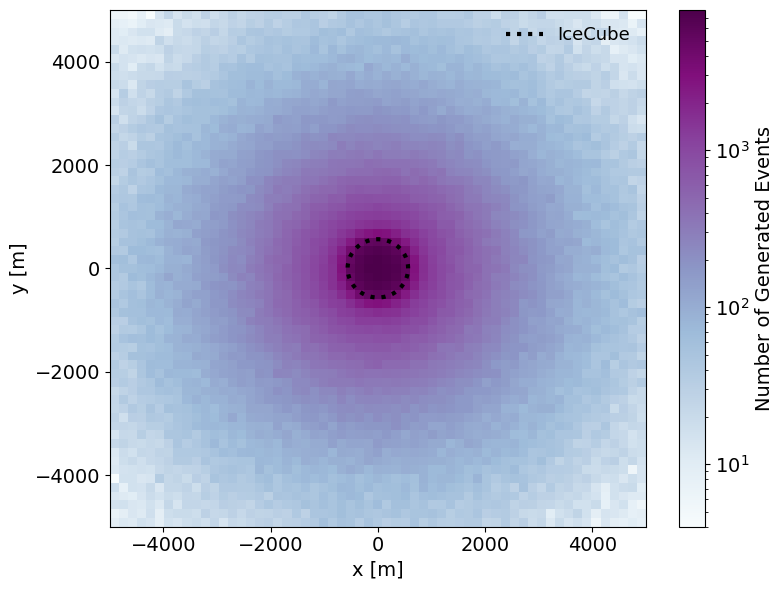

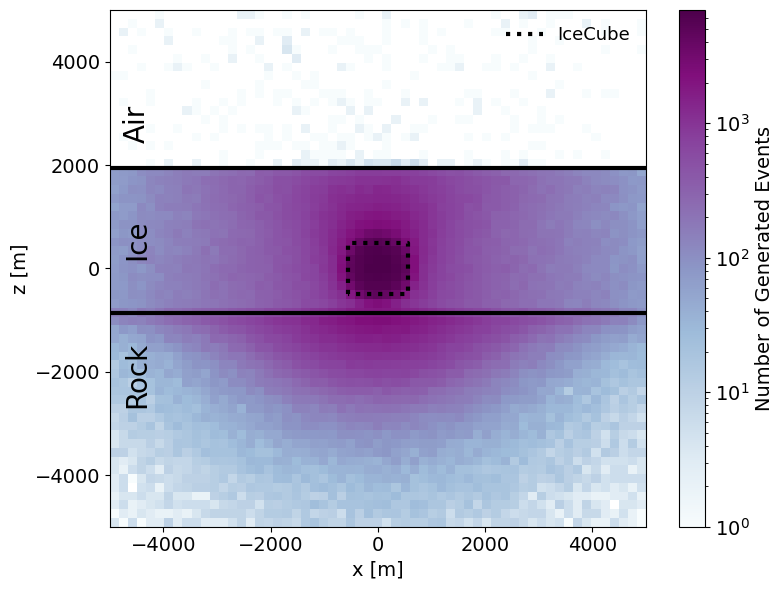

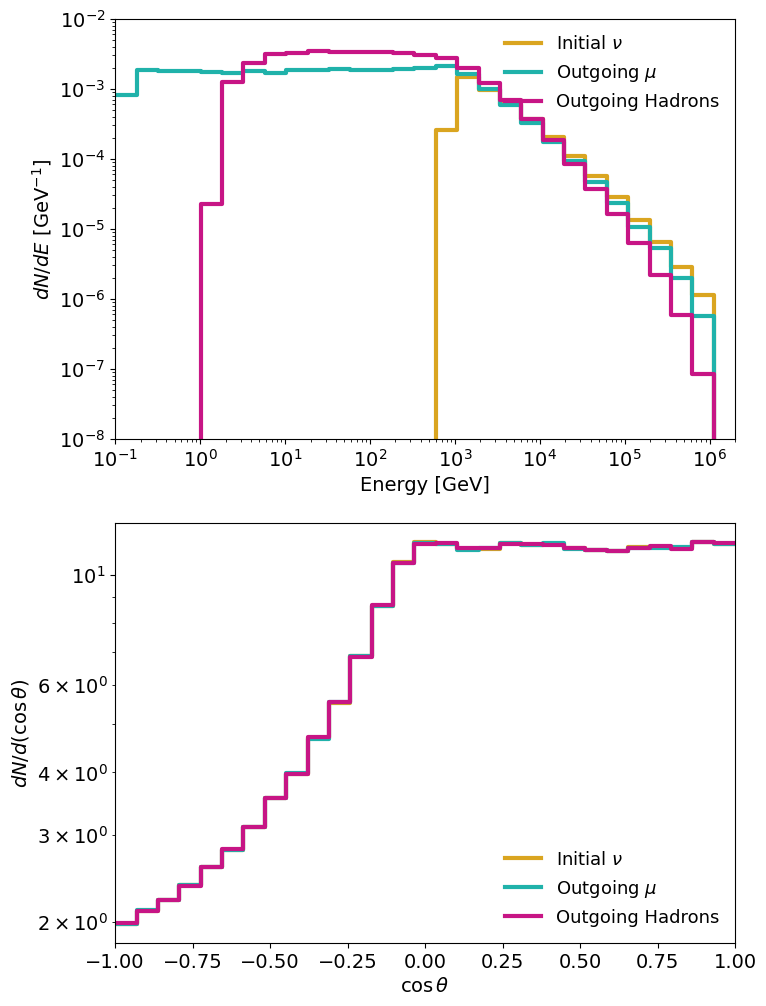

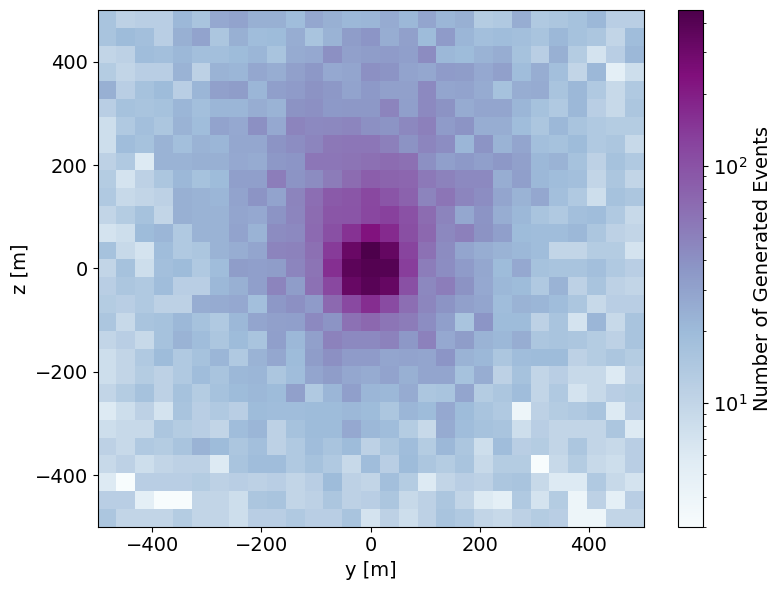

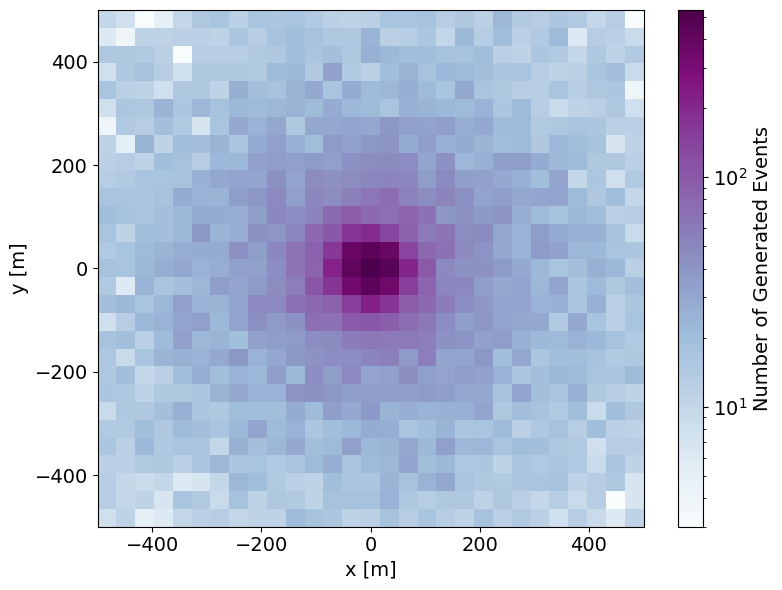

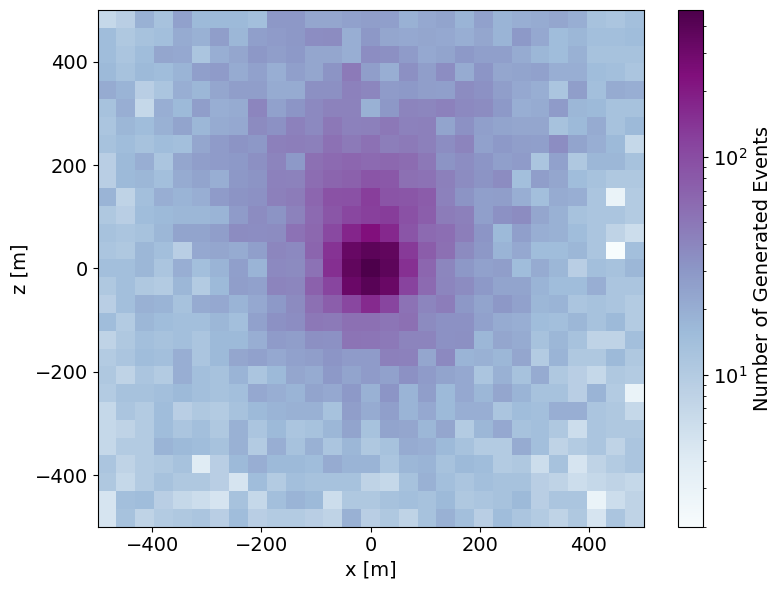

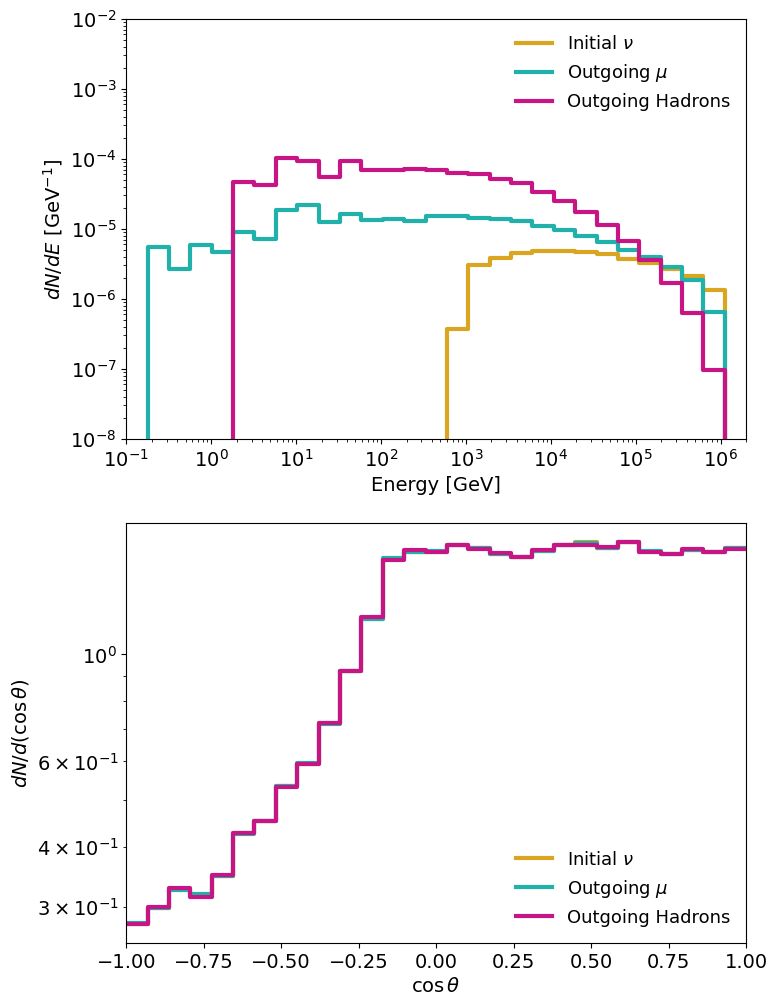

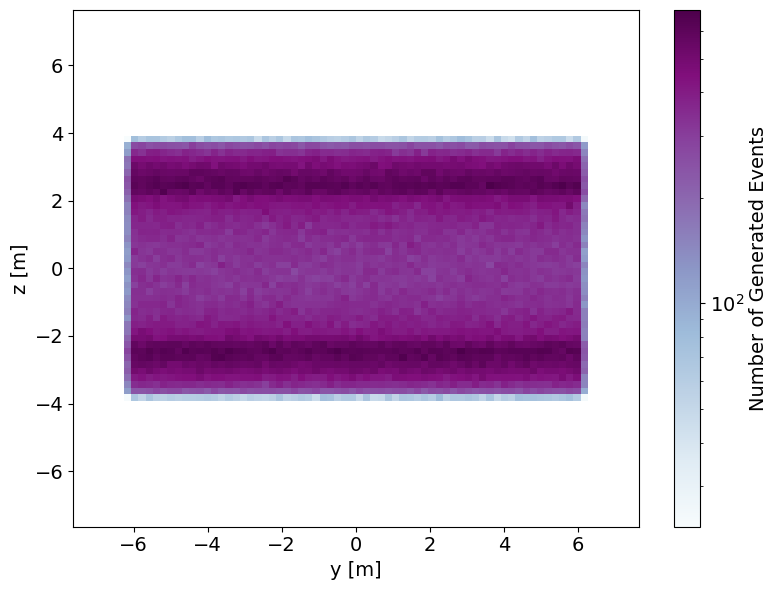

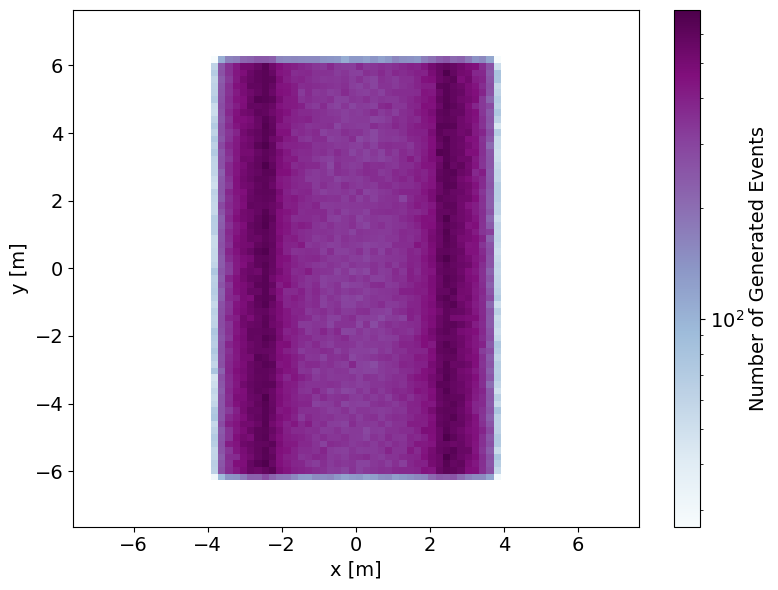

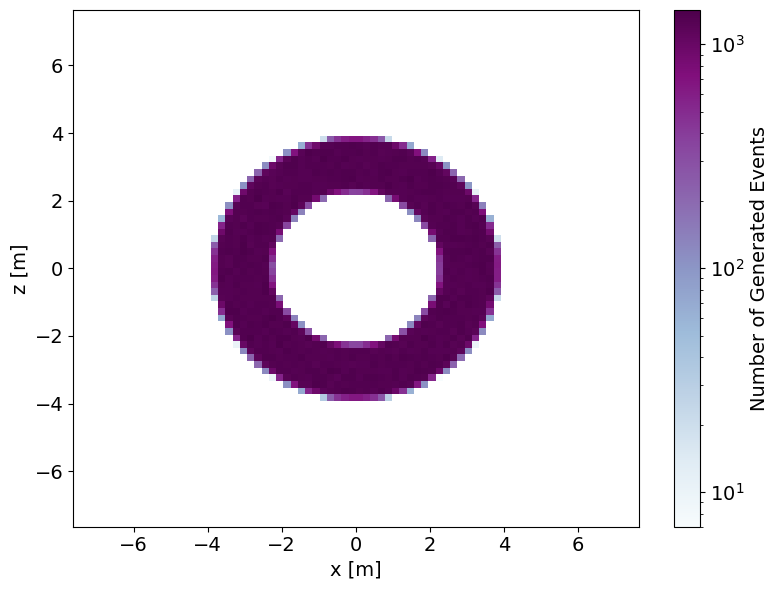

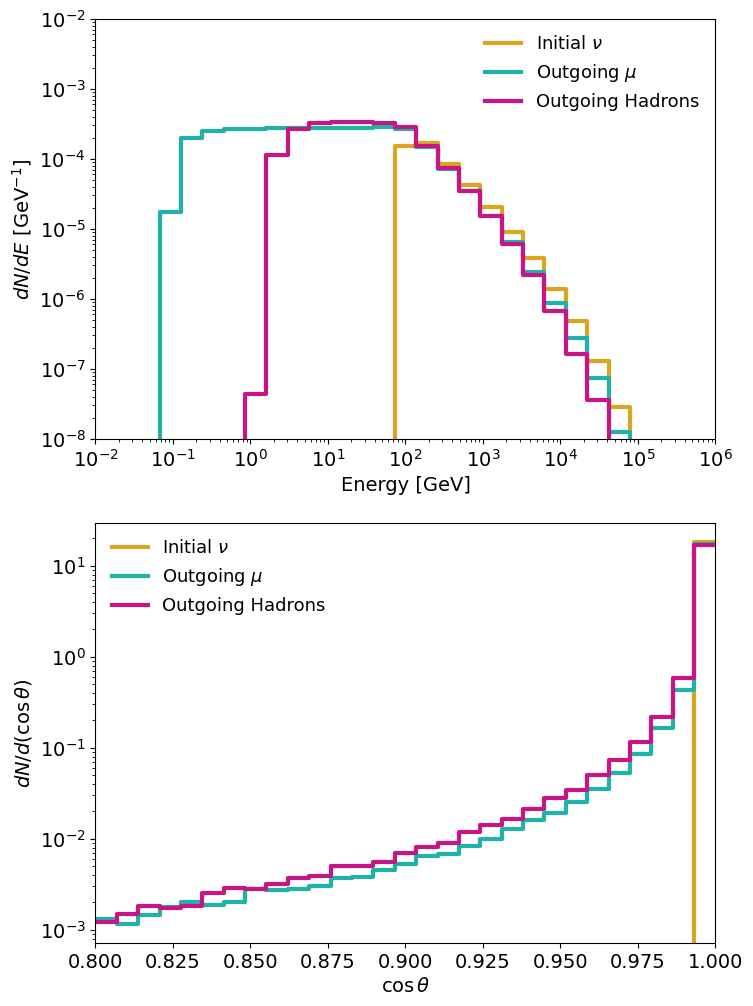

In [4]:
for k in filename.keys():
    #if k!="ATLAS": continue
    data = awk.from_parquet("output/"+filename[k])
    vx = np.array(np.squeeze(data["vertex"]))
    if k=="ATLAS": 
        x = 3.82*2
        nbins=79
    elif k=="DUNE": 
        x = 500
        nbins=30
    else: 
        x = 5000
        nbins=60
    
    plt.hist2d(vx[:,1],vx[:,2],bins=np.linspace(-x,x,nbins),norm=LogNorm(),cmap="BuPu")
    if k=="IceCube":
        plt.plot([-564.19,-564.19,564.19,564.19,-564.19],[-500,500,500,-500,-500],color="black",linestyle="dotted",label="IceCube")
        iceair_boundary = 6374134-6372184
        rockice_boundary = 6371324 - 6372184
        plt.plot([-x,x],[iceair_boundary,iceair_boundary],color="black")
        plt.plot([-x,x],[rockice_boundary,rockice_boundary],color="black")
        plt.text(-0.95*x,1.3*iceair_boundary,"Air",fontsize=20,rotation=90)
        plt.text(-0.95*x,0.5*0.5*(iceair_boundary+rockice_boundary),"Ice",fontsize=20,rotation=90)
        plt.text(-0.95*x,3*rockice_boundary,"Rock",fontsize=20,rotation=90)
        plt.legend()
    plt.xlabel("y [m]")
    plt.ylabel("z [m]")
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.tight_layout()
    plt.savefig("figures/%s_yz.pdf"%k,dpi=100)
    plt.show()
    
    plt.hist2d(vx[:,0],vx[:,1],bins=np.linspace(-x,x,nbins),norm=LogNorm(),cmap="BuPu")
    if k=="IceCube":
        r = 564.19
        theta = np.linspace(0,2*np.pi,100)
        plt.plot(r*np.cos(theta),r*np.sin(theta),color="black",linestyle="dotted",label="IceCube")
        plt.legend()
    plt.xlabel("x [m]")
    plt.ylabel("y [m]")
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.tight_layout()
    plt.savefig("figures/%s_xy.pdf"%k,dpi=100)
    plt.show()
    
    plt.hist2d(vx[:,0],vx[:,2],bins=np.linspace(-x,x,nbins),norm=LogNorm(),cmap="BuPu")
    if k=="IceCube":
        plt.plot([-564.19,-564.19,564.19,564.19,-564.19],[-500,500,500,-500,-500],color="black",linestyle="dotted",label="IceCube")
        iceair_boundary = 6374134-6372184
        rockice_boundary = 6371324 - 6372184
        plt.plot([-x,x],[iceair_boundary,iceair_boundary],color="black")
        plt.plot([-x,x],[rockice_boundary,rockice_boundary],color="black")
        plt.text(-0.95*x,1.3*iceair_boundary,"Air",fontsize=20,rotation=90)
        plt.text(-0.95*x,0.5*0.5*(iceair_boundary+rockice_boundary),"Ice",fontsize=20,rotation=90)
        plt.text(-0.95*x,3*rockice_boundary,"Rock",fontsize=20,rotation=90)
        plt.legend()
    plt.xlabel("x [m]")
    plt.ylabel("z [m]")
    c = plt.colorbar()
    c.set_label("Number of Generated Events")
    plt.tight_layout()
    plt.savefig("figures/%s_xz.pdf"%k,dpi=100)
    plt.show()
    
    plot_kinematics(data,k,savestr="figures/%s"%k)
    

In [5]:
from siren.LIController import LIController
from siren import math,detector
def plot_Aeff(data,controller,fid_vol,gamma,**kwargs):
    nu_flag = data["primary_type"]=="ParticleType.NuMu"
    nu_momenta = np.squeeze(data["primary_momentum"][nu_flag])
    # muon
    muon_flag = data["secondary_types"]=='ParticleType.MuMinus'
    muon_momenta = data["secondary_momenta"][muon_flag]
    # mask out entries that are not muon
    muon_momenta = awk.mask(muon_momenta, awk.num(muon_momenta,axis=2)>0)
    muon_momenta = np.squeeze(muon_momenta[~awk.is_none(muon_momenta,axis=1)])
    if gamma==2:
        norm = 1. / (1./(1e3) - 1./(1e6))
    elif gamma==1:
        norm = np.log(1e6) - np.log(1e3)
    norm *= 4*np.pi # solid angle
    dphi_dE = nu_momenta[:,0]**-gamma * norm # normalized
    #Aeff = nu_momenta[:,0]/dphi_dE
    positions = np.squeeze(data["vertex"])
    directions = muon_momenta[:,1:]
    intersections = []
    for i,(pos,dr) in enumerate(zip(positions,directions)):
        print(i,end="\r")
        pos = math.Vector3D(pos)
        dr = math.Vector3D(dr)
        dr.normalize()
        geo_pos = controller.detector_model.DetPositionToGeoPosition(pos)
        geo_dr = controller.detector_model.DetDirectionToGeoDirection(dr)
        ints = fid_vol.Intersections(geo_pos.get(),geo_dr.get())
        intersections.append(len(ints)>0)
    x,bins = np.histogram(nu_momenta[:,0],weights=np.array(intersections)*data["event_weight"]/dphi_dE,bins=kwargs["bins"])
    bw = bins[1:] - bins[:-1]
    plt.step(bins[:-1],x/bw,label=kwargs["label"])
    

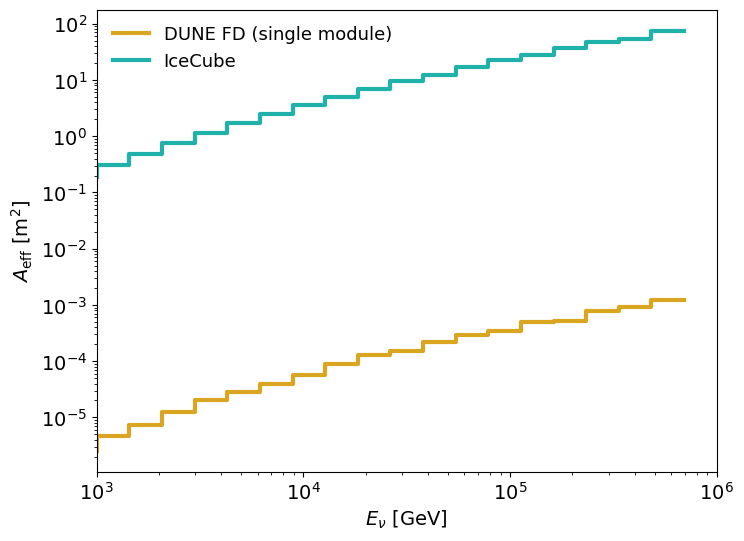

In [6]:
for k in ["DUNE","IceCube"]:
    controller = LIController(1,k if k=="IceCube" else k+"FD")
    for x in controller.detector_model.Sectors:
        if k=="DUNE" and x.name=="dune_far_detector":
            fid_vol = x.geo
        elif k=="IceCube" and x.name=="icecube":
            fid_vol = x.geo
    kwargs = {"bins":np.logspace(3,6,20),
              "label":k if k=="IceCube" else k+" FD (single module)"}
    data = awk.from_parquet("output/"+filename[k])
    plot_Aeff(data,controller,fid_vol,gamma=1 if k=="DUNE" else 2, **kwargs)
plt.legend()
plt.loglog()
plt.xlim(1e3,1e6)
plt.xlabel(r"$E_{\nu}~[{\rm GeV}]$")
plt.ylabel(r"$A_{\rm eff}~[{\rm m}^2]$")
plt.savefig("figures/Aeff_IceCube_DUNE.pdf",dpi=100)
plt.show()